# Implementing LeNET on Spectrograms 
Setting the random seed = 42 so that the code is reproducable .

# Building LeNET architecture

In [50]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [56]:

img_size = 32
batch_size = 32

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_dir = "/content/drive/MyDrive/heartbeat-data_new"

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 4188, Val: 523, Test: 524


In [57]:
for X, y in train_loader:
    print("Batch X shape:", X.shape)
    print("Batch y shape:", y.shape)
    break


Batch X shape: torch.Size([32, 1, 32, 32])
Batch y shape: torch.Size([32])


In [61]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # compute flattened size
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Corrected from 16 * 29 * 29
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

model = LeNet().to(device)

In [62]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)


In [64]:
num_epochs = 100

train_losses, val_losses = [], []
train_accs, val_accs = [], []
precisions, recalls, f1s = [], [], []

best_val_f1 = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    all_train_preds, all_train_labels = [], []

    for X, y in train_loader:
        X, y = X.to(device), y.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        preds = (outputs >= 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(y.cpu().numpy())

    train_loss /= total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.float().unsqueeze(1).to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item() * X.size(0)

            preds = (outputs >= 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(y.cpu().numpy())

    val_loss /= total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    precision = precision_score(val_labels, val_preds)
    recall = recall_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    if f1 > best_val_f1:
        best_val_f1 = f1
        torch.save(model.state_dict(), 'best_lenet.pth')

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
          f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

# Save metrics
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'precisions': precisions,
    'recalls': recalls,
    'f1s': f1s
}, 'lenet_metrics.pth')


Epoch 1/100 | Train Acc: 0.7691 | Val Acc: 0.7572 | Precision: 0.6738 | Recall: 0.9805 | F1: 0.7987
Epoch 2/100 | Train Acc: 0.8293 | Val Acc: 0.8203 | Precision: 0.7447 | Recall: 0.9650 | F1: 0.8407
Epoch 3/100 | Train Acc: 0.8520 | Val Acc: 0.8260 | Precision: 0.8578 | Recall: 0.7743 | F1: 0.8139
Epoch 4/100 | Train Acc: 0.8491 | Val Acc: 0.8566 | Precision: 0.8760 | Recall: 0.8249 | F1: 0.8497
Epoch 5/100 | Train Acc: 0.8438 | Val Acc: 0.8107 | Precision: 0.7582 | Recall: 0.9027 | F1: 0.8242
Epoch 6/100 | Train Acc: 0.8496 | Val Acc: 0.8662 | Precision: 0.8258 | Recall: 0.9222 | F1: 0.8713
Epoch 7/100 | Train Acc: 0.8749 | Val Acc: 0.8662 | Precision: 0.8816 | Recall: 0.8405 | F1: 0.8606
Epoch 8/100 | Train Acc: 0.8696 | Val Acc: 0.8642 | Precision: 0.8298 | Recall: 0.9105 | F1: 0.8683
Epoch 9/100 | Train Acc: 0.8818 | Val Acc: 0.8623 | Precision: 0.8179 | Recall: 0.9261 | F1: 0.8686
Epoch 10/100 | Train Acc: 0.8816 | Val Acc: 0.8662 | Precision: 0.8148 | Recall: 0.9416 | F1: 0.8736

In [65]:
model.load_state_dict(torch.load('best_lenet.pth'))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.float().unsqueeze(1).to(device)
        outputs = model(X)
        preds = (outputs >= 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.9217557251908397


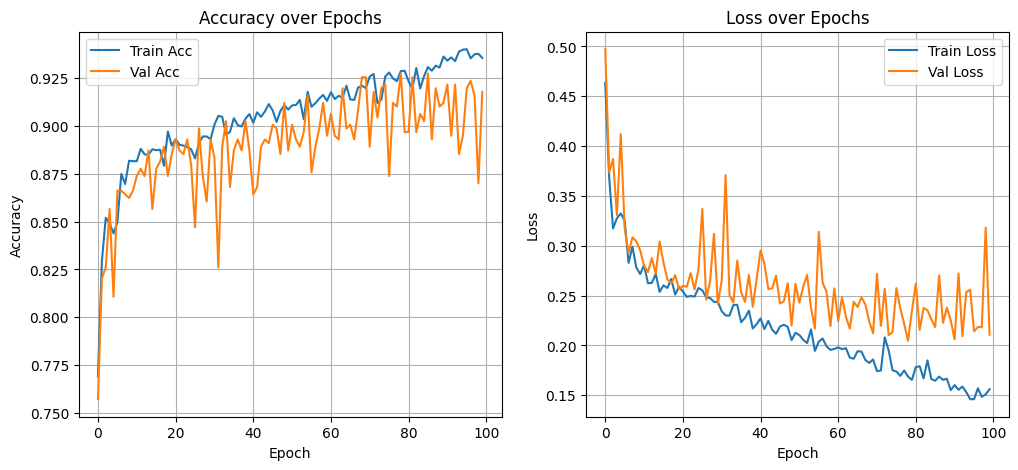

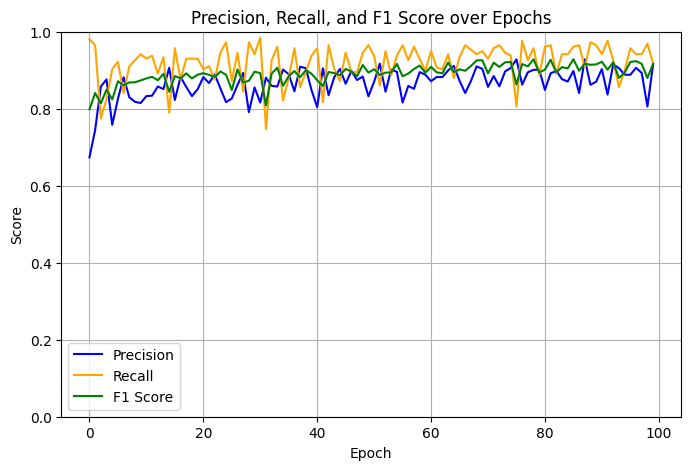

In [66]:
import matplotlib.pyplot as plt

metrics = torch.load('lenet_metrics.pth')

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(metrics['train_accs'], label='Train Acc')
plt.plot(metrics['val_accs'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(metrics['train_losses'], label='Train Loss')
plt.plot(metrics['val_losses'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.figure(figsize=(8,5))
plt.plot(metrics['precisions'], label='Precision', color='blue')
plt.plot(metrics['recalls'], label='Recall', color='orange')
plt.plot(metrics['f1s'], label='F1 Score', color='green')

plt.title('Precision, Recall, and F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0, 1)  # scores are between 0 and 1
plt.legend()
plt.grid(True)
plt.show()

plt.show()


Final-code

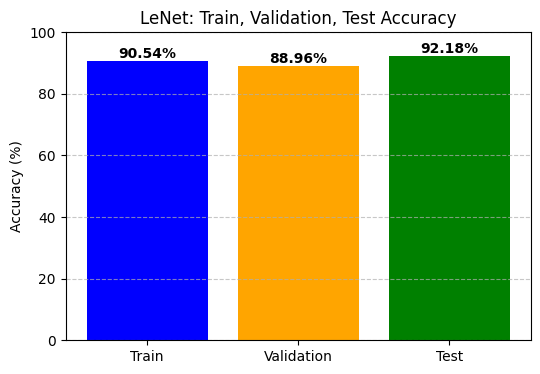

In [67]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

metrics = torch.load('lenet_metrics.pth')

train_acc_avg = sum(metrics['train_accs']) / len(metrics['train_accs'])
val_acc_avg   = sum(metrics['val_accs']) / len(metrics['val_accs'])

model.load_state_dict(torch.load('best_lenet.pth'))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).float().unsqueeze(1)

        outputs = model(X_batch)
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)

accuracies = [train_acc_avg*100, val_acc_avg*100, test_acc*100]
labels = ['Train', 'Validation', 'Test']

plt.figure(figsize=(6,4))
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
plt.ylabel('Accuracy (%)')
plt.title('LeNet: Train, Validation, Test Accuracy')
plt.ylim(0, 100)

for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
